In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, glob
import cv2, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
#from patchify import patchify
from PIL import Image
#import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.utils import normalize
from tensorflow.keras.models import load_model
from tqdm import tqdm
from random import sample
import pickle
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.preprocessing import LabelEncoder
from keras.utils import normalize
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
class_labels = {
    1: 'Wall',
    2: 'Building',
    3: 'Sky',
    4: 'Floor',
    5: 'Tree',
    6: 'Ceiling',
    7: 'Route',
    8: 'Bed',
    10: 'grass',
    13: 'Person',
    26 : 'House',
    38:  'bathtub',
    66:  'toilet'
}

In [ ]:
class_colors = {

    1: (120, 120, 120),    # Wall
    2: (180, 120, 120),    # Building
    3: (6, 230, 230),      # Sky
    4: (80, 50, 50),       # Floor
    5: (4, 200, 3),        # Tree
    6: (120, 120, 80),     # Ceiling
    7: (140, 140, 140),    # Route
    8: (204,5,255),        # Bed
    10: (4, 250, 7),       # grass
    13: (150, 5, 61),      # Person
    26 : (255,9,224),      # House
    38: (102, 8, 225),     # bathtub
    66: (0,255,133),       # toilet

}
class_colors_keys = list(class_colors.keys())

In [ ]:
#Training and testing Paths
train_path = r"/content/drive/MyDrive/ADEChallengeData2016/images/training"
anno_path = r"/content/drive/MyDrive/ADEChallengeData2016/annotations/training"

In [ ]:
#Validation Paths
valid_path = r"/content/drive/MyDrive/ADEChallengeData2016/images/validation"
valid_anno_path = r"/content/drive/MyDrive/ADEChallengeData2016/annotations/validation"

In [ ]:
image_dataset,mask_dataset,masked_image_dataset = [],[],[]

In [ ]:
class_labels = {

    1: 'Wall',
    2: 'Building',
    3: 'Sky',
    4: 'Floor',
    5: 'Tree',
    6: 'Ceiling',
    7: 'Route',
    8: 'Bed',
    10: 'grass',
    13: 'Person',
    26 : 'House',
    38:  'bathtub',
    66:  'toilet'
}

In [ ]:
def load_images_bw_mask(image_path):
    image = cv2.imread(image_path,0)
    #print(image.shape)
    #image = cv2.cvtColor(image)
    image = cv2.resize(image, (128, 128))
    image = Image.fromarray(image)
    image = np.array(image)
    return image

In [ ]:

def load_images_bw(image_path):
    image = cv2.imread(image_path,1)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    image = Image.fromarray(image)
    image = np.array(image)
    return image



In [45]:
cd input/train_masks


/content/drive/My Drive/input/train_masks


In [ ]:
ls -lrt /content/drive/MyDrive/input/train_masks/Wall/

total 0


In [ ]:
mkdir

In [56]:
cd input/train_masks

[Errno 2] No such file or directory: 'input/train_masks'
/content/drive/MyDrive/input


In [57]:
cd train_masks

/content/drive/MyDrive/input/train_masks


In [ ]:
!rm -rf /content/drive/MyDrive/input/Yolo_ds

In [ ]:
class_colors = {

    1: (120, 120, 120),    # Wall

   2: (180, 120, 120),    # Building
    3: (6, 230, 230),      # Sky
    4: (80, 50, 50),       # Floor
    5: (4, 200, 3),        # Tree
    6: (120, 120, 80),     # Ceiling
    7: (140, 140, 140),    # Route
    8: (204,5,255),        # Bed
    10: (4, 250, 7),       # grass
    13: (150, 5, 61),      # Person
    26 : (255,9,224),      # House
    38: (102, 8, 225),     # bathtub
    66: (0,255,133),       # toilet
}

In [ ]:
category_ids = {

   'Wall':1,
    'Building':2,
    'Sky':3,
   'Floor':4,
   'Tree':5,
    'Ceiling':6,
    'Route':7,
    'Bed':8,
    'grass':9,
    'Person':10,
    'House':11,
   'bathtub':12,
     'toilet':13
}

In [ ]:
cd ../val_masks

/content/drive/MyDrive/input/val_masks


In [70]:
pwd


'/content/drive/MyDrive/input/train_masks'

In [71]:
for i in list(category_ids.keys()):
    os.mkdir(i)

In [54]:
cd ..


/content/drive/MyDrive/input


In [67]:
#Read first required images
for i in range(3000,3002):
    # Load the segmentation mask
    image_name = 'ADE_train_0000'+str(i)+'.png'
    mask = load_images_bw_mask(os.path.join(anno_path,image_name))
    print("before: ",np.unique(mask))


    # Apply class label changes and relabelling other classes to background
    for label in np.unique(mask):
        if label not in class_colors_keys:
            mask[mask == label] = 0


    print("After : ",np.unique(mask))


    # Load the Image
    train_image_name = 'ADE_train_0000'+str(i)+'.jpg'
    #print(os.path.join(train_path,train_image_name))
    image = load_images_bw(os.path.join(train_path,train_image_name))

    #creating a numpy array of image size
    output = np.zeros_like(image)

    # Apply colors to the mask based on class labels
    labels = list(class_colors.values())
    name_of_img = 'ADE_train_0000'+str(i)+'.png'
    for class_label, class_color in class_colors.items():
        # Create binary mask for the current class
        binary_mask = np.zeros_like(mask, dtype=np.uint8)
        binary_mask[mask == class_label] = 255

        # Save the binary mask in the corresponding class folder
        class_folder = class_labels[class_label]
        print(class_folder)
        os.makedirs(class_folder, exist_ok=True)  # Create class folder if it doesn't exist
        mask_filename = f'{image_name}'
        cv2.imwrite(os.path.join(class_folder, mask_filename), binary_mask)

    #Adding Images, masks and Coloured Masks
    image_dataset.append(image[:,:,0])
    mask_dataset.append(mask)
    masked_image_dataset.append(output)


    '''
    #output[mask == class_label] = class_colors[class_label]
        folder = class_labels[class_label]
        print(folder)
        image_path = os.path.join('/content/drive/MyDrive/Coco_mask/',folder)
        print(image_path)
        print("name",name_of_img)
        image_name = os.path.join(image_path,name_of_img)
        print("folder: ",image_name)
        cv2.imwrite(image_name, output)
    #Adding Images, masks and Coloured Masks
    image_dataset.append(image[:,:,0])
    mask_dataset.append(mask)
    masked_image_dataset.append(output)
    '''


before:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  32  33  35  36  38  39
  41  42  44  45  46  47  48  50  51  52  53  54  57  58  60  62  63  65
  67  71  72  75  81  82  90 108 131 136 148]
After :  [ 0  1  2  3  4  5  6  7  8 10 13 26 38]
Wall
Building
Sky
Floor
Tree
Ceiling
Route
Bed
grass
Person
House
bathtub
toilet
before:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  30  31  32  33  34  35  36
  37  38  41  47  49  50  52  54  55  59  60  66  67  68  72  82  85  98
  99 100 104 117 119 120 126]
After :  [ 0  1  2  3  4  5  6  7  8 10 13 26 38 66]
Wall
Building
Sky
Floor
Tree
Ceiling
Route
Bed
grass
Person
House
bathtub
toilet


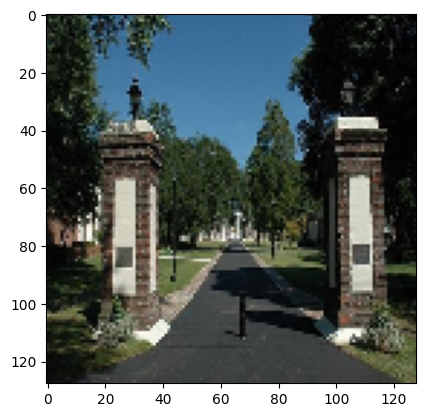

In [75]:
img = load_images_bw("/content/drive/MyDrive/ADEChallengeData2016/images/training/ADE_train_00005000.jpg")
plt.imshow(img)

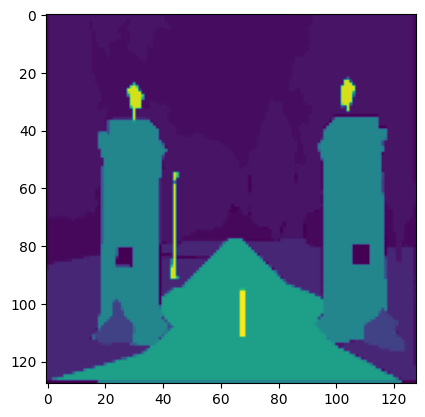

In [81]:
img = load_images_bw_mask("/content/drive/MyDrive/ADEChallengeData2016/annotations/training/ADE_train_00005000.png")
plt.imshow(img)

In [94]:
#Read first required images
for i in range(5000,6002):
    # Load the segmentation mask
    image_name = 'ADE_train_0000'+str(i)+'.png'
    mask = load_images_bw_mask(os.path.join(anno_path,image_name))

    # Load the Image
    train_image_name = 'ADE_train_0000'+str(i)+'.jpg'
    #print(os.path.join(train_path,train_image_name))
    image = load_images_bw(os.path.join(train_path,train_image_name))

    # Apply class label changes and relabelling other classes to background
    for label in np.unique(mask):
        if label not in class_colors_keys:
            mask[mask == label] = 0
    # Calculate background percentage
    total_pixels = mask.shape[0] * mask.shape[1]
    background_pixels = np.sum(mask == 0)
    background_percentage = (background_pixels / total_pixels) * 100


    if (background_percentage>90):
        continue
    else:
        #creating a numpy array of image size
        output = np.zeros_like(image)

        # Apply colors to the mask based on class labels
        labels = list(class_colors.values())

        for class_label, class_color in class_colors.items():
          # Create binary mask for the current class

          binary_mask = np.zeros_like(mask, dtype=np.uint8)
          binary_mask[mask == class_label] = 255

          total_pixels = binary_mask.shape[0] * binary_mask.shape[1]
          background_pixels = np.sum(binary_mask == 0)
          background_percentage = (background_pixels / total_pixels) * 100


          if background_percentage<90:
            class_folder = class_labels[class_label]

            os.makedirs(class_folder, exist_ok=True)  # Create class folder if it doesn't exist
            mask_filename = f'{image_name}'
            cv2.imwrite(os.path.join(class_folder, mask_filename), binary_mask)


          # Save the binary mask in the corresponding class folder




    '''
    #output[mask == class_label] = class_colors[class_label]
        folder = class_labels[class_label]
        print(folder)
        image_path = os.path.join('/content/drive/MyDrive/Coco_mask/',folder)
        print(image_path)
        print("name",name_of_img)
        image_name = os.path.join(image_path,name_of_img)
        print("folder: ",image_name)
        cv2.imwrite(image_name, output)
    #Adding Images, masks and Coloured Masks
    image_dataset.append(image[:,:,0])
    mask_dataset.append(mask)
    masked_image_dataset.append(output)
    '''


In [95]:
cd ../val_masks

/content/drive/MyDrive/input/val_masks


In [100]:
#Read first required images
for i in range(1000,2000):
    # Load the segmentation mask
    image_name = 'ADE_val_0000'+str(i)+'.png'
    mask = load_images_bw_mask(os.path.join(valid_anno_path,image_name))

    # Load the Image
    train_image_name = 'ADE_val_0000'+str(i)+'.jpg'
    #print(os.path.join(train_path,train_image_name))
    image = load_images_bw(os.path.join(valid_path,train_image_name))

    # Apply class label changes and relabelling other classes to background
    for label in np.unique(mask):
        if label not in class_colors_keys:
            mask[mask == label] = 0
    # Calculate background percentage
    total_pixels = mask.shape[0] * mask.shape[1]
    background_pixels = np.sum(mask == 0)
    background_percentage = (background_pixels / total_pixels) * 100


    if (background_percentage>90):
        continue
    else:
        #creating a numpy array of image size
        output = np.zeros_like(image)

        # Apply colors to the mask based on class labels
        labels = list(class_colors.values())

        for class_label, class_color in class_colors.items():
          # Create binary mask for the current class

          binary_mask = np.zeros_like(mask, dtype=np.uint8)
          binary_mask[mask == class_label] = 255

          total_pixels = binary_mask.shape[0] * binary_mask.shape[1]
          background_pixels = np.sum(binary_mask == 0)
          background_percentage = (background_pixels / total_pixels) * 100


          if background_percentage<90:
            class_folder = class_labels[class_label]

            os.makedirs(class_folder, exist_ok=True)  # Create class folder if it doesn't exist
            mask_filename = f'{image_name}'
            cv2.imwrite(os.path.join(class_folder, mask_filename), binary_mask)


          # Save the binary mask in the corresponding class folder




    '''
    #output[mask == class_label] = class_colors[class_label]
        folder = class_labels[class_label]
        print(folder)
        image_path = os.path.join('/content/drive/MyDrive/Coco_mask/',folder)
        print(image_path)
        print("name",name_of_img)
        image_name = os.path.join(image_path,name_of_img)
        print("folder: ",image_name)
        cv2.imwrite(image_name, output)
    #Adding Images, masks and Coloured Masks
    image_dataset.append(image[:,:,0])
    mask_dataset.append(mask)
    masked_image_dataset.append(output)
    '''


In [ ]:
#Read first required images
for i in range(1000,2001):
    # Load the segmentation mask
    image_name = 'ADE_val_0000'+str(i)+'.png'
    mask = load_images_bw_mask(os.path.join(valid_anno_path,image_name))
    print("before: ",np.unique(mask))


    # Apply class label changes and relabelling other classes to background
    for label in np.unique(mask):
        if label not in class_colors_keys:
            mask[mask == label] = 0


    print("After : ",np.unique(mask))


    # Load the Image
    train_image_name = 'ADE_val_0000'+str(i)+'.jpg'
    #print(os.path.join(train_path,train_image_name))
    image = load_images_bw(os.path.join(valid_path,train_image_name))

    #creating a numpy array of image size
    output = np.zeros_like(image)

    # Apply colors to the mask based on class labels
    labels = list(class_colors.values())
    name_of_img = 'ADE_val_0000'+str(i)+'.png'
    for class_label, class_color in class_colors.items():
        # Create binary mask for the current class
        binary_mask = np.zeros_like(mask, dtype=np.uint8)
        binary_mask[mask == class_label] = 255

        # Save the binary mask in the corresponding class folder
        class_folder = class_labels[class_label]
        os.makedirs(class_folder, exist_ok=True)  # Create class folder if it doesn't exist
        mask_filename = f'{image_name}'
        cv2.imwrite(os.path.join(class_folder, mask_filename), binary_mask)

    #Adding Images, masks and Coloured Masks
    image_dataset.append(image[:,:,0])
    mask_dataset.append(mask)
    masked_image_dataset.append(output)


    '''
    #output[mask == class_label] = class_colors[class_label]
        folder = class_labels[class_label]
        print(folder)
        image_path = os.path.join('/content/drive/MyDrive/Coco_mask/',folder)
        print(image_path)
        print("name",name_of_img)
        image_name = os.path.join(image_path,name_of_img)
        print("folder: ",image_name)
        cv2.imwrite(image_name, output)
    #Adding Images, masks and Coloured Masks
    image_dataset.append(image[:,:,0])
    mask_dataset.append(mask)
    masked_image_dataset.append(output)
    '''


before:  [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 20 29 32 34 35 36 39 40
 43 44 45 47 48 51 53 55 60 61 64 67 68 70 75 76 77 80 82 83 84 92 94]
After :  [ 0  1  2  3  4  5  6  7  8 10 13]
before:  [0 1 2 3 4 5]
After :  [0 1 2 3 4 5]
before:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  48  55  56  61  63  65  69  72  75
  77  79  81  82  83  84  87  88 101 103]
After :  [ 0  1  2  3  4  5  6  7  8 10 13 26 38]
before:  [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 24 25 26
 28 29 30 33 34 35 36 37 39 40 41 43 44 45 46 47 48 49 51 52 53 54 55 56
 57 58 61 63 65 67 71 73 75 76 83 84 85 86 87 88 89 90 91]
After :  [ 0  1  2  3  4  5  6  7  8 10 13 26]
before:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24
 25 26 27 28 29 30 31 32]
After :  [ 0  1  2  3  4  5  6  7  8 10 13 26]
before:  [ 0  1  2  3

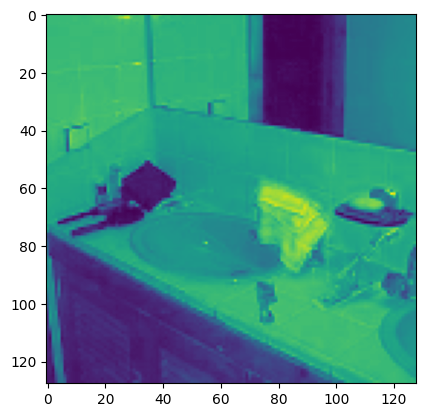

In [ ]:
plt.imshow(image_dataset[5])

In [ ]:
z =load_images_bw("/kaggle/working/Wall/ADE_train_00004003.png")
plt.imshow(z)

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


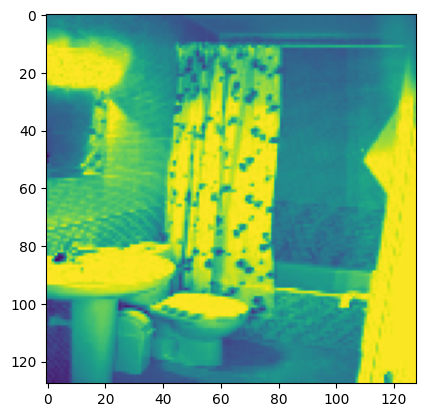

In [ ]:
plt.imshow(image_dataset[4])

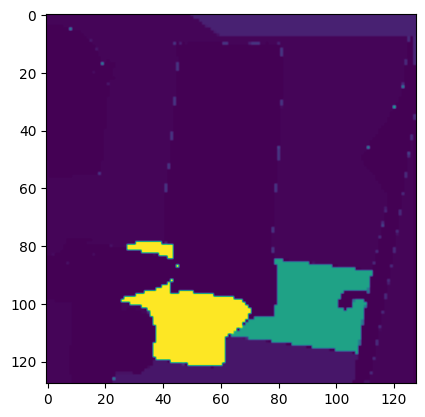

In [ ]:
plt.imshow(mask_dataset[4])

In [ ]:
np.unique(mask_dataset[0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 13, 26, 38], dtype=uint8)

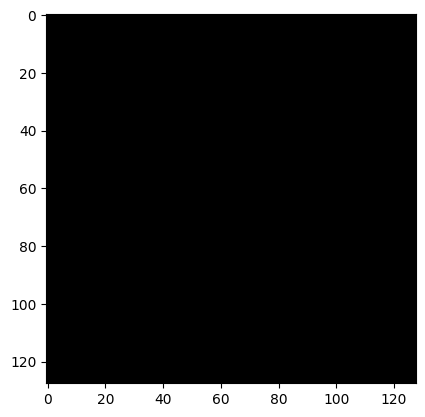

In [ ]:
plt.imshow(masked_image_dataset[4])

In [ ]:
!rm -rf /kaggle/working/*

In [165]:
# https://youtu.be/NYeJvxe5nYw
"""
This code automates the conversion of binary masks representing different
object categories into the COCO (Common Objects in Context) JSON format.

The code is based on the following folder structure for training and validation
images and masks. You need to change the code based on your folder structure
or organize your data to the format below.

EM-platelet-multi/   #Primary data folder for the project
├── input/           #All input data is stored here.
│   ├── train_images/
│   │   ├── image01.png
│   │   ├── image02.png
│   │   └── ...
│   ├── train_masks/        #All binary masks organized in respective sub-directories.
│   │   ├── Alpha/
│   │   │   ├── image01.png
│   │   │   ├── image02.png
│   │   │   └── ...
│   │   ├── Cells/
│   │   │   ├── image01.png
│   │   │   ├── image02.png
│   │   │   └── ...
│   │   ├── Mito/
│   │   │   ├── image01.png
│   │   │   ├── image02.png
│   │   │   └── ...
│   │   └── Vessels/
│   │       ├── image01.png
│   │       ├── image02.png
│   │       └── ...
│   ├── val_images/
│   │   ├── image05.png
│   │   ├── image06.png
│   │   └── ...
│   └── val_masks/
│       ├── Alpha/
│       │   ├── image05.png
│       │   ├── image06.png
│       │   └── ...
│       ├── Cells/
│       │   ├── image05.png
│       │   ├── image06.png
│       │   └── ...
│       ├── Mito/
│       │   ├── image05.png
│       │   ├── image06.png
│       │   └── ...
│       └── Vessels/
│           ├── image05.png
│           ├── image06.png
│           └── ...
└── ...


For each binary mask, the code extracts contours using OpenCV.
These contours represent the boundaries of objects within the images.This is a key
step in converting binary masks to polygon-like annotations.

Convert the contours into annotations, including
bounding boxes, area, and segmentation information. Each annotation is
associated with an image ID, category ID, and other properties required by the COCO format.

The code also creates an images section containing
metadata about the images, such as their filenames, widths, and heights.
In my example, I have used exactly the same file names for all images and masks
so that a given mask can be easily mapped to the image.

All the annotations, images, and categories are
assembled into a dictionary that follows the COCO JSON format.
This includes sections for "info," "licenses," "images," "categories," and "annotations."

Finally, the assembled COCO JSON data is saved to a file,
making it ready to be used with tools and frameworks that support the COCO data format.


"""

import glob
import json
import os
import cv2

# Label IDs of the dataset representing different categories

category_ids = {

   'Wall':1,
    'Building':2,
    'Sky':3,
   'Floor':4,
   'Tree':5,
    'Ceiling':6,
    'Route':7,
    'Bed':8,
    'grass':9,
    'Person':10,
    'House':11,
   'bathtub':12,
     'toilet':13
}

MASK_EXT = 'png'
ORIGINAL_EXT = 'png'
image_id = 0
annotation_id = 0

def images_annotations_info(maskpath):
    """
    Process the binary masks and generate images and annotations information.

    :param maskpath: Path to the directory containing binary masks
    :return: Tuple containing images info, annotations info, and annotation count
    """
    global image_id, annotation_id
    annotations = []
    images = []

    # Iterate through categories and corresponding masks
    for category in category_ids.keys():
        for mask_image in glob.glob(os.path.join(maskpath, category, f'*.{MASK_EXT}')):
            original_file_name = f'{os.path.basename(mask_image).split(".")[0]}.{ORIGINAL_EXT}'
            mask_image_open = cv2.imread(mask_image)

            # Get image dimensions
            height, width, _ = mask_image_open.shape

            # Create or find existing image annotation
            if original_file_name not in map(lambda img: img['file_name'], images):
                image = {
                    "id": image_id + 1,
                    "width": width,
                    "height": height,
                    "file_name": original_file_name,
                }
                images.append(image)
                image_id += 1
            else:
                image = [element for element in images if element['file_name'] == original_file_name][0]

            # Find contours in the mask image
            gray = cv2.cvtColor(mask_image_open, cv2.COLOR_BGR2GRAY)
            _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]

            # Create annotation for each contour
            for contour in contours:
                bbox = cv2.boundingRect(contour)
                area = cv2.contourArea(contour)
                segmentation = contour.flatten().tolist()

                annotation = {
                    "iscrowd": 0,
                    "id": annotation_id,
                    "image_id": image['id'],
                    "category_id": category_ids[category],
                    "bbox": bbox,
                    "area": area,
                    "segmentation": [segmentation],
                }

                # Add annotation if area is greater than zero
                if area > 0:
                    annotations.append(annotation)
                    annotation_id += 1

    return images, annotations, annotation_id


def process_masks(mask_path, dest_json):
    global image_id, annotation_id
    image_id = 0
    annotation_id = 0

    # Initialize the COCO JSON format with categories
    coco_format = {
        "info": {},
        "licenses": [],
        "images": [],
        "categories": [{"id": value, "name": key, "supercategory": key} for key, value in category_ids.items()],
        "annotations": [],
    }

    # Create images and annotations sections
    coco_format["images"], coco_format["annotations"], annotation_cnt = images_annotations_info(mask_path)

    # Save the COCO JSON to a file
    with open(dest_json, "w") as outfile:
        json.dump(coco_format, outfile, sort_keys=True, indent=4)

    print("Created %d annotations for images in folder: %s" % (annotation_cnt, mask_path))

if __name__ == "__main__":
    train_mask_path = "/content/drive/MyDrive/input/train_masks/"
    train_json_path = "/content/drive/MyDrive/input/train_masks/train.json"
    process_masks(train_mask_path, train_json_path)

    valid_mask_path = "/content/drive/MyDrive/input/val_masks/"
    valid_json_path = "/content/drive/MyDrive/input/val_masks/valid.json"
    process_masks(valid_mask_path, valid_json_path)



Created 9779 annotations for images in folder: /content/drive/MyDrive/input/train_masks/
Created 12133 annotations for images in folder: /content/drive/MyDrive/input/val_masks/


In [166]:
# https://youtu.be/NYeJvxe5nYw
"""
This code transforms a dataset of images and annotations into a format suitable
for training a YOLO (You Only Look Once) object detection model, and it also
creates a YAML configuration file required for training the model.

It reads coco style json annotations supplied as a single json file and also
images as input.

Here are the key steps in the code:

1. Convert Images to YOLO Format: The convert_to_yolo function takes paths for
input images and annotations (in JSON format), and directories to store the
output images and labels. It then performs the following operations:

- Reads the input JSON file containing annotations.
- Copies all PNG images from the input directory to the output directory.
- Normalizes the polygon segmentation data related to each image and writes
them to text files, mapping them to the appropriate category
(e.g., Alpha, Cells, Mito, Vessels).
- The resulting text files contain information about the object category and the normalized coordinates of the polygons that describe the objects.

2. Create YAML Configuration File: The create_yaml function takes paths to the input JSON file containing categories, training, validation, and optional test paths. It then:

- Extracts the category names and the number of classes.
- Constructs a dictionary containing information about class names, the number
of classes, and paths to the training, validation, and test datasets.
- Writes this dictionary to a YAML file, which can be used as a configuration
file for training a model (e.g., a YOLO model).



The text annotation file consists of lines representing individual object
annotations, with each line containing the class ID followed by the normalized
coordinates of the polygon describing the object.

Example structure of the YOLO annotation file:

<class_id> <normalized_polygon_coordinate_1> <normalized_polygon_coordinate_2> ... <normalized_polygon_coordinate_n>
0 0.123456 0.234567 0.345678 0.456789 ...

"""


import json
import os
import shutil
import yaml

# Function to convert images to YOLO format
def convert_to_yolo(input_images_path, input_json_path, output_images_path, output_labels_path):
    # Open JSON file containing image annotations
    f = open(input_json_path)
    data = json.load(f)
    f.close()




    # Create directories for output images and labels
    os.makedirs(output_images_path, exist_ok=True)
    os.makedirs(output_labels_path, exist_ok=True)

    # List to store filenames
    file_names = []

    for filename in os.listdir(input_images_path):
        if filename.endswith(".png"):
            print(filename)
            source = os.path.join(input_images_path, filename)
            destination = os.path.join(output_images_path, filename)
            shutil.copy(source, destination)
            file_names.append(filename)



    # Function to get image annotations
    def get_img_ann(image_id):
        return [ann for ann in data['annotations'] if ann['image_id'] == image_id]

    # Function to get image data
    def get_img(filename):
        return next((img for img in data['images'] if img['file_name'] == filename), None)

    # Iterate through filenames and process each image

    for filename in file_names:
        z = [img for img in data['images'] if img['file_name'] == filename]
        print(filename)
        img = get_img(filename)
        print(img)
        if img:
          img_id = img['id']
          img_w = img['width']
          img_h = img['height']
          img_ann = get_img_ann(img_id)
          print(img_ann)

          # Write normalized polygon data to a text file
          if img_ann:
              with open(os.path.join(output_labels_path, f"{os.path.splitext(filename)[0]}.txt"), "a") as file_object:
                  for ann in img_ann:
                      current_category = ann['category_id'] - 1
                      polygon = ann['segmentation'][0]
                      normalized_polygon = [format(coord / img_w if i % 2 == 0 else coord / img_h, '.6f') for i, coord in enumerate(polygon)]
                      file_object.write(f"{current_category} " + " ".join(normalized_polygon) + "\n")


# Function to create a YAML file for the dataset
def create_yaml(input_json_path, output_yaml_path, train_path, val_path, test_path=None):
    with open(input_json_path) as f:
        data = json.load(f)

    # Extract the category names
    names = [category['name'] for category in data['categories']]

    # Number of classes
    nc = len(names)

    # Create a dictionary with the required content
    yaml_data = {
        'names': names,
        'nc': nc,
        'test': test_path if test_path else '',
        'train': train_path,
        'val': val_path
    }

    # Write the dictionary to a YAML file
    with open(output_yaml_path, 'w') as file:
        yaml.dump(yaml_data, file, default_flow_style=False)


if __name__ == "__main__":
    base_input_path = "/content/drive/MyDrive/input/"

    base_output_path = "/content/drive/MyDrive/Yolo_ds/"

    # Processing validation dataset (if needed)


    convert_to_yolo(
        input_images_path=os.path.join(base_input_path, "val_images/"),
        input_json_path=os.path.join(base_input_path, "val_masks/valid.json"),

        output_images_path=os.path.join(base_output_path, "valid/images"),
        output_labels_path=os.path.join(base_output_path, "valid/labels")
    )


    # Processing training dataset
    convert_to_yolo(
        input_images_path=os.path.join(base_input_path, "train_images/"),
        input_json_path= os.path.join(base_input_path,"train_masks/train.json"),

        output_images_path=os.path.join(base_output_path, "train/images"),
        output_labels_path=os.path.join(base_output_path, "train/labels")
    )

    # Creating the YAML configuration file

    create_yaml(
        input_json_path=os.path.join(base_input_path, "train_masks/train.json"),
        output_yaml_path=os.path.join(base_output_path, "data.yaml"),
        train_path="/content/drive/MyDrive/Yolo_ds/train",
        val_path="/content/drive/MyDrive/Yolo_ds/valid",
        #test_path='../test/images'  # or None if not applicable
    )

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
 cd /content/drive/MyDrive/Yolo_ds

/content/drive/MyDrive/Yolo_ds


In [ ]:
for i in list(category_ids.keys()):
    os.mkdir(i)

In [147]:
import shutil
copy_from = r"/content/drive/MyDrive/ADEChallengeData2016/images/training"
copy_to = r"/content/drive/MyDrive/input/train_images/"
for i in range(5000,6002):
    # Load the segmentation mask
    image_name = 'ADE_train_0000'+str(i)+'.jpg'
    new_image_name = 'ADE_train_0000'+str(i)+'.png'
    origin = os.path.join(copy_from, image_name)
    target = os.path.join(copy_to, new_image_name)

    print(origin)
    print(target)

    shutil.copy(origin, target)




/content/drive/MyDrive/ADEChallengeData2016/images/training/ADE_train_00005000.jpg
/content/drive/MyDrive/input/train_images/ADE_train_00005000.png
/content/drive/MyDrive/ADEChallengeData2016/images/training/ADE_train_00005001.jpg
/content/drive/MyDrive/input/train_images/ADE_train_00005001.png
/content/drive/MyDrive/ADEChallengeData2016/images/training/ADE_train_00005002.jpg
/content/drive/MyDrive/input/train_images/ADE_train_00005002.png
/content/drive/MyDrive/ADEChallengeData2016/images/training/ADE_train_00005003.jpg
/content/drive/MyDrive/input/train_images/ADE_train_00005003.png
/content/drive/MyDrive/ADEChallengeData2016/images/training/ADE_train_00005004.jpg
/content/drive/MyDrive/input/train_images/ADE_train_00005004.png
/content/drive/MyDrive/ADEChallengeData2016/images/training/ADE_train_00005005.jpg
/content/drive/MyDrive/input/train_images/ADE_train_00005005.png
/content/drive/MyDrive/ADEChallengeData2016/images/training/ADE_train_00005006.jpg
/content/drive/MyDrive/input/

In [164]:
import shutil
copy_from = r"/content/drive/MyDrive/ADEChallengeData2016/images/validation"
copy_to = r"/content/drive/MyDrive/input/val_images/"
for i in range(1000,2001):
    # Load the segmentation mask
    image_name = 'ADE_val_0000'+str(i)+'.jpg'
    new_image_name = 'ADE_val_0000'+str(i)+'.png'
    origin = os.path.join(copy_from, image_name)
    target = os.path.join(copy_to, new_image_name)

    print(origin)
    print(target)

    shutil.copy(origin, target)

/content/drive/MyDrive/ADEChallengeData2016/images/validation/ADE_val_00001000.jpg
/content/drive/MyDrive/input/val_images/ADE_val_00001000.png
/content/drive/MyDrive/ADEChallengeData2016/images/validation/ADE_val_00001001.jpg
/content/drive/MyDrive/input/val_images/ADE_val_00001001.png
/content/drive/MyDrive/ADEChallengeData2016/images/validation/ADE_val_00001002.jpg
/content/drive/MyDrive/input/val_images/ADE_val_00001002.png
/content/drive/MyDrive/ADEChallengeData2016/images/validation/ADE_val_00001003.jpg
/content/drive/MyDrive/input/val_images/ADE_val_00001003.png
/content/drive/MyDrive/ADEChallengeData2016/images/validation/ADE_val_00001004.jpg
/content/drive/MyDrive/input/val_images/ADE_val_00001004.png
/content/drive/MyDrive/ADEChallengeData2016/images/validation/ADE_val_00001005.jpg
/content/drive/MyDrive/input/val_images/ADE_val_00001005.png
/content/drive/MyDrive/ADEChallengeData2016/images/validation/ADE_val_00001006.jpg
/content/drive/MyDrive/input/val_images/ADE_val_00001

In [ ]:
cd ../..

'/content/drive/MyDrive/input/train_masks'

<ipython-input-167-cab97ceb8550>:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')


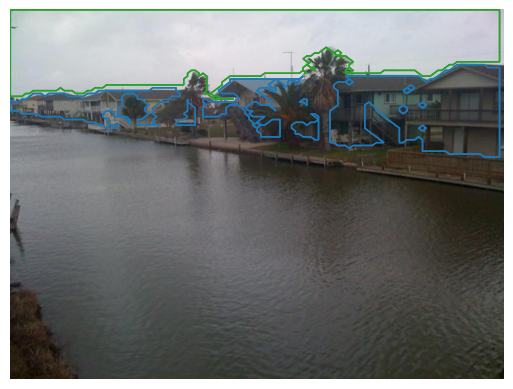

In [167]:
# https://youtu.be/NYeJvxe5nYw
"""
This code defines a function to display an image with its corresponding annotations.
It reads an image and its associated annotation file in the YOLO v8 text format,
then plots the image along with colored polygons representing the annotated regions.
The polygons are drawn according to the coordinates provided in the annotation file,
and colors are assigned based on the category ID.

"""

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

def display_image_with_annotations(image_path, annotation_path, colors=None):
    # Load image using OpenCV and convert it from BGR to RGB color space
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_h, img_w, _ = image.shape

    # Create a figure and axis to display the image
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    ax.axis('off')  # Turn off the axes

    # Define a default color map if none is provided
    if colors is None:
        colors = plt.cm.get_cmap('tab10')

    # Open the annotation file and process each line
    with open(annotation_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            category_id = int(parts[0])
            # Choose color based on category ID, looping through color map if more than 10 categories
            color = colors(category_id % 10)
            # Extract normalized polygon coordinates and denormalize them
            polygon = [float(coord) for coord in parts[1:]]
            polygon = [coord * img_w if i % 2 == 0 else coord * img_h for i, coord in enumerate(polygon)]
            # Reshape into (num_points, 2) array
            polygon = [(polygon[i], polygon[i+1]) for i in range(0, len(polygon), 2)]
            # Create a Polygon patch using the denormalized coordinates
            patch = patches.Polygon(polygon, closed=True, edgecolor=color, fill=False)
            # Add the patch to the plot to display the annotated region
            ax.add_patch(patch)

    plt.show()  # Display the image with annotations

# Example usage with specified image and annotation paths
image_path = "/content/drive/MyDrive/Yolo_ds/train/images/ADE_train_00005005.png"
annotation_path = "/content/drive/MyDrive/Yolo_ds/train/labels/ADE_train_00005005.txt"
display_image_with_annotations(image_path, annotation_path)

<ipython-input-168-8634f237afbb>:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')


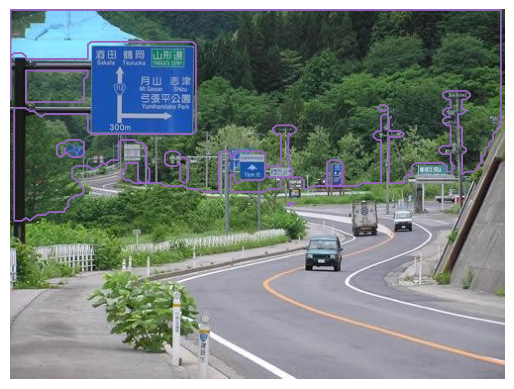

In [168]:
# https://youtu.be/NYeJvxe5nYw
"""
This code defines a function to display an image with its corresponding annotations.
It reads an image and its associated annotation file in the YOLO v8 text format,
then plots the image along with colored polygons representing the annotated regions.
The polygons are drawn according to the coordinates provided in the annotation file,
and colors are assigned based on the category ID.

"""

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

def display_image_with_annotations(image_path, annotation_path, colors=None):
    # Load image using OpenCV and convert it from BGR to RGB color space
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_h, img_w, _ = image.shape

    # Create a figure and axis to display the image
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    ax.axis('off')  # Turn off the axes

    # Define a default color map if none is provided
    if colors is None:
        colors = plt.cm.get_cmap('tab10')

    # Open the annotation file and process each line
    with open(annotation_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            category_id = int(parts[0])
            # Choose color based on category ID, looping through color map if more than 10 categories
            color = colors(category_id % 10)
            # Extract normalized polygon coordinates and denormalize them
            polygon = [float(coord) for coord in parts[1:]]
            polygon = [coord * img_w if i % 2 == 0 else coord * img_h for i, coord in enumerate(polygon)]
            # Reshape into (num_points, 2) array
            polygon = [(polygon[i], polygon[i+1]) for i in range(0, len(polygon), 2)]
            # Create a Polygon patch using the denormalized coordinates
            patch = patches.Polygon(polygon, closed=True, edgecolor=color, fill=False)
            # Add the patch to the plot to display the annotated region
            ax.add_patch(patch)

    plt.show()  # Display the image with annotations

# Example usage with specified image and annotation paths
image_path = "/content/drive/MyDrive/Yolo_ds/valid/images/ADE_val_00001002.png"
annotation_path = "/content/drive/MyDrive/Yolo_ds/valid/labels/ADE_val_00001002.txt"
display_image_with_annotations(image_path, annotation_path)